# Задание

20.	 В столовой самообслуживания имеется один раздаточный пункт, на котором отпускаются как первые, так и вторые блюда. Поток посетителей столовой — простейший с интенсивностью $ x $; на отпуск как первого, так и второго блюда идет случайное время, распределенное по показательному закону с одним и тем же параметром $ р $. Некоторые посетители берут и первое, и второе (доля таких посетителей равна $ q $), другие — только второе (доля 1 — $ q $). Найти: 1) условия, при которых существует устойчивый, стационарный режим работы столовой; 2) среднюю длину очереди и среднее время пребывания посетителей в столовой, если посетитель съедает одно блюдо в среднем за время $ t $, а два блюда — за время 2 $ t $. 

Устойчивость — свойство системы сохранять состояние равновесия или некоторого движения при воздействии на нее факторов, вызывающих определенные начальные отклонения.


In [102]:
import numpy as np
import simpy as sp
import statistics as st
import matplotlib.pyplot as plt
import random
import math

# СМО
Системой массового обслуживания (СМО) называется любая система для
выполнения заявок, поступающих в неё в случайные моменты времени. 

$ x $ - интенсивность потока посетителей \
$ p $ - параметр для показательного распределения потока обслуживания \
$ q $ - доля посетителей которые берут 2 блюда 

Класс который предоставляет типы посетителей:

In [103]:
import enum

class VisitorsTypes(enum.Enum):
    one_dish = 1
    two_dish = 2

Класс СМО:

In [104]:
class QueueSystem(object):
    def __init__(self, env, x, p, q):
        self.env = env

        self.x = x
        self.p = p
        self.q = q
        self.resources = sp.Resource(env, 1)

        self.serve_times = []
        self.queue_times = []
        self.queue_len = []
        self.serve_items = []

    def start(self, action):
        while True:
            yield self.env.timeout(1 / self.x)
            rand = random.random()
            visitor_type = VisitorsTypes.two_dish if rand <= self.q else VisitorsTypes.one_dish
            self.env.process(action(self, visitor_type))

    def serve(self, visitor_type):
        yield self.env.timeout(np.random.exponential(1.0 / self.p))
        if visitor_type == VisitorsTypes.two_dish:
            yield self.env.timeout(np.random.exponential(1.0 / self.p))

Функция которая реализует процес обработки заявок:

In [105]:
def serve(queue_system, visitor_type):
  with queue_system.resources.request() as request:
      queue_current_len = len(queue_system.resources.queue)
      qs_current_count = queue_system.resources.count
      queue_system.queue_len.append(queue_current_len)
      start = queue_system.env.now
      yield request
      queue_system.queue_times.append(queue_system.env.now - start)
      yield queue_system.env.process(queue_system.serve(visitor_type))
      queue_system.serve_times.append((queue_system.env.now - start, visitor_type))
      queue_system.serve_items.append(queue_current_len + qs_current_count)

# Подсчет результатов работы СМО

In [106]:
def get_avg_time_in_canteen(queue_system, t):
    all_time_in_canteen = []
    for time, visitor_type in queue_system.serve_times:
        all_time_in_canteen.append(time + visitor_type.value * t)
    return st.mean(all_time_in_canteen)

In [107]:
def get_avg_queue_len(queue_system):
    return st.mean(queue_system.queue_len)

Финальные вероятности:

In [108]:
def get_experimental_final_probabilities(queue_system):
  items = np.array(queue_system.serve_items)
  return [(len(items[items == i]) / len(items)) for i in range(1, 4)]

Графики:

In [109]:
def plot_queue_system_probabilities(queue_system, interval_count, count_p, theoretical_probabilities):
  intervals = np.array_split(queue_system.serve_items, interval_count)
  for i in range(1, count_p):
    interval_probabilities = []
    for interval in intervals:
      interval_probabilities.append(len(interval[interval == i]) / len(interval))
    plt.figure(figsize=(5, 5))
    plt.bar(range(len(interval_probabilities)), interval_probabilities)
    plt.title(f"Probabilitiy {i}")
    plt.axhline(y = theoretical_probabilities[i], xmin = 0, xmax = len(interval_probabilities), color='red')
    plt.show()

# Тест кейсы

In [110]:
def get_teor_prop(x, p, q):
    rho = get_rho(x, p, q)
    p0 = 1 - rho
    teor_prob = []
    teor_prob.append(p0)
    for i in range(1, 3):
        teor_prob.append((rho ** i) * p0)
    return teor_prob

In [111]:
def get_rho(x, p, q):
    rho = x / (p + (p * q))
    if rho < 1:
        print("rho = " + str(rho) + " => СМО устойчива")
        if (x < p + (p * q)):
            print(str(x) + " < " + str(p + (p * q)) + " СМО устойчива и стационарна")
    else:
        print("rho = " + str(rho) + " => СМО не устойчива")
    return rho

In [112]:
def plot_histograms(theoretical_probabilities, experimental_probabilities):
    plt.style.use('default')
    fig, (ax1, ax2,) = plt.subplots(1, 2, figsize=(25, 5))
    
    ax1.set_title('Теоретические финальные вероятности')
    ax1.bar(range(len(theoretical_probabilities)), theoretical_probabilities, width = 0.2)
    
    ax2.set_title('Эмпирические финальные вероятности')
    ax2.bar(range(len(experimental_probabilities)), experimental_probabilities, width = 0.2)
    plt.show()

In [113]:
def run_qs(x, p, q, t, work_time):
    env = sp.Environment()
    queue_system = QueueSystem(env, x, p, q)
    env.process(queue_system.start(serve))
    env.run(until = work_time)
    print("Средняя длина очереди: " + str(get_avg_queue_len(queue_system)))
    print("Среднее время пребывания посетителей в столовой: " + str(get_avg_time_in_canteen(queue_system, t)))
    final_probabilities = get_experimental_final_probabilities(queue_system)
    print("Финальные вероятности:" + str(final_probabilities))
    teor_probabilities = get_teor_prop(x, p, q)
    print("Теоретический вероятности:" + str(teor_probabilities))
    plot_histograms(teor_probabilities, final_probabilities)
    plot_queue_system_probabilities(queue_system, 25, 4, teor_probabilities)

Если $ \rho < n $ то процесс обслуживания устойчив. \
Если $ \rho >= n => $ СМО работает не устойчиво.

Если интенсивность потока заявок $ x < p $ (интенсивности потока обслуживания) и $ \rho < 1 $, \
то СМО устойчива и стационарна.


Тест 1
Средняя длина очереди: 0.9415777777777777
Среднее время пребывания посетителей в столовой: 119.93343824694976
Финальные вероятности:[0.5067500250000926, 0.25747132396786654, 0.12413749680554373]
rho = 0.5 => СМО устойчива
45 < 90.0 СМО устойчива и стационарна
Теоретический вероятности:[0.5, 0.25, 0.125]


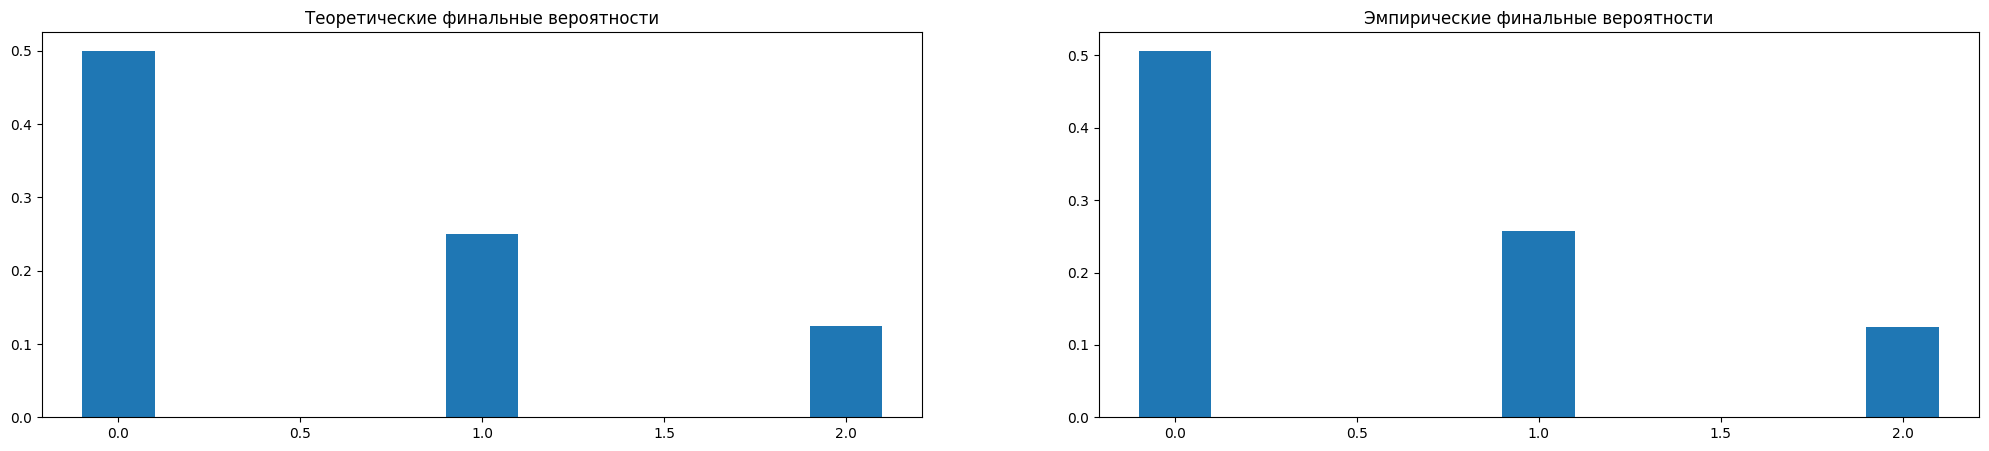

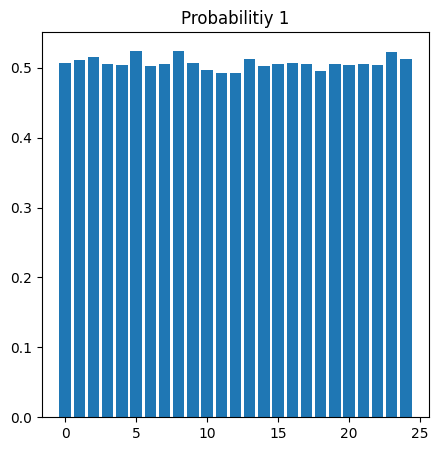

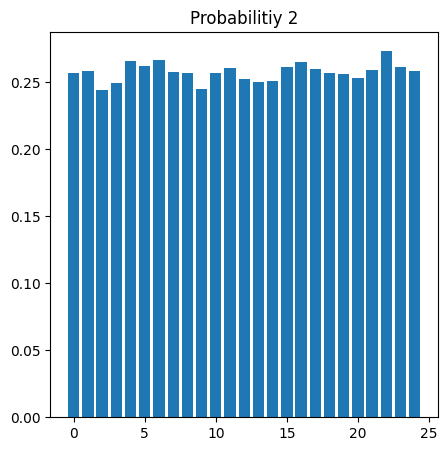

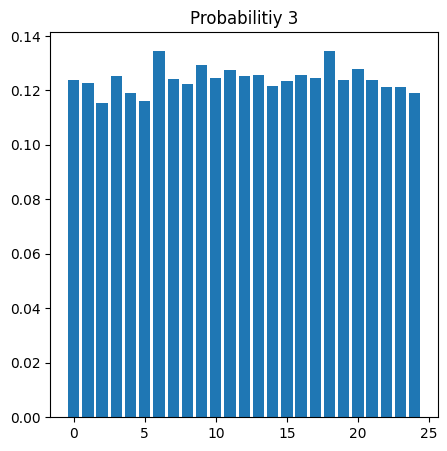

In [114]:
print("Тест 1")
x = 45
p = 75
q = 0.2
t = 100
work_time = 6000
run_qs(x, p, q, t, work_time)